In [1]:
# load the BTC long term dataset
import pandas as pd

btc_5y_df = pd.read_csv('../backend/data/btcusdt_1d.csv', index_col=0, parse_dates=True)

print(btc_5y_df.head().to_markdown())

| timestamp           | symbol   |    open |    high |   low |   close |   volume |
|:--------------------|:---------|--------:|--------:|------:|--------:|---------:|
| 2020-04-20 00:00:00 | BTCUSDT  | 7121.4  | 7220    |  6751 | 6826.83 |  90149.5 |
| 2020-04-21 00:00:00 | BTCUSDT  | 6828.98 | 6940    |  6762 | 6841.37 |  60109.7 |
| 2020-04-22 00:00:00 | BTCUSDT  | 6841.36 | 7156.38 |  6818 | 7125.14 |  61486.4 |
| 2020-04-23 00:00:00 | BTCUSDT  | 7125.12 | 7738    |  7020 | 7482.39 | 102774   |
| 2020-04-24 00:00:00 | BTCUSDT  | 7483.96 | 7615.96 |  7388 | 7505    |  60182.1 |


In [2]:
fig_kwargs = {
    "renderer": "png",
    "width": 1000,
    "height": 700,
}

In [3]:
# xgboost_experiment = setup(btc_5y_df.loc[:,'close'], fh = 3, fold = 5, session_id = 123)
# close prices
btc_5y_close_df = btc_5y_df.loc[:, 'close']

print("\n--- Setting up Data Split ---")

# Ensure data is sorted by time
btc_5y_close_df = btc_5y_close_df.sort_index()
btc_5y_close_df = btc_5y_close_df.to_frame()

# Create lag features
for lag in range(1, 3):  # Lags from 1 to 7 days
    btc_5y_close_df[f'lag_{lag}'] = btc_5y_close_df['close'].shift(lag)

# Drop NaN values caused by lagging
btc_5y_close_df = btc_5y_close_df.dropna()

# Restore the 'close' column name
# btc_5y_close_df = btc_5y_close_df.rename(columns={'close': 'close'})
btc_5y_close_df.head()


--- Setting up Data Split ---


,close,lag_1,lag_2
timestamp,,,
2020-04-22,7125.14,6841.37,6826.83
2020-04-23,7482.39,7125.14,6841.37
2020-04-24,7505.00,7482.39,7125.14
2020-04-25,7538.67,7505.00,7482.39
2020-04-26,7693.10,7538.67,7505.00


In [4]:
# Train-Test Split (last 365 days as test set)
split_date = btc_5y_close_df.index[-30]  
btc_train = btc_5y_close_df.loc[btc_5y_close_df.index <= split_date].copy()
btc_test = btc_5y_close_df.loc[btc_5y_close_df.index > split_date].copy()

btc_train.head()


,close,lag_1,lag_2
timestamp,,,
2020-04-22,7125.14,6841.37,6826.83
2020-04-23,7482.39,7125.14,6841.37
2020-04-24,7505.00,7482.39,7125.14
2020-04-25,7538.67,7505.00,7482.39
2020-04-26,7693.10,7538.67,7505.00


In [5]:
import pandas as pd
from pycaret.time_series import *

# PyCaret TS experiment - for exp smoothing, univariate data is required.
exp = TSForecastingExperiment().setup(
    data=btc_5y_close_df['close'], 
    target="close",
    session_id=123, 
    fold=3,  # K-fold cross-validation,
    fh=30,
    fig_kwargs=fig_kwargs
)

# Train exponential smoothing Model
best = exp.create_model('exp_smooth')




,Description,Value
0,session_id,123
1,Target,close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1823, 1)"
5,Transformed data shape,"(1823, 1)"
6,Transformed train set shape,"(1793, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-19,0.4269,0.3652,2941.7857,3503.1379,0.0304,0.0302,-0.3083
1,2025-01-18,1.0027,0.8376,6864.1048,7989.3231,0.0699,0.0667,-4.7394
2,2025-02-17,1.2936,1.0897,8765.1855,10315.0927,0.1040,0.0969,-2.5617
Mean,NaT,0.9077,0.7642,6190.3587,7269.1846,0.0681,0.0646,-2.5365
SD,NaT,0.3601,0.3003,2424.6576,2827.2049,0.0300,0.0273,1.8091


In [6]:
# check the performance of the baseline model using the train set (not the validation data held off in the earlier step)

y_predict = exp.predict_model(best)
pred_dt = y_predict.index.to_timestamp()

y_true_pred = btc_5y_close_df.loc[pred_dt.min():pred_dt.max()]
y_true_pred["predictions"] = y_predict.values




,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.3785,0.3447,2606.9765,3303.5303,0.0319,0.0311,-0.7080


In [7]:
import plotly.express as px

fig = px.line(y_true_pred, y=['close', 'predictions'], template='plotly_dark', labels={"value" : "close price $"})

fig.show()


In [8]:
tuned_exp_smooth = exp.tune_model(best)



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-19,0.3656,0.3201,2519.0651,3070.1891,0.0259,0.0259,-0.0049
1,2025-01-18,0.7030,0.6028,4812.3397,5749.4800,0.0492,0.0475,-1.9724
2,2025-02-17,1.2409,1.0321,8407.9969,9769.9236,0.0996,0.0933,-2.1951
Mean,NaT,0.7698,0.6517,5246.4672,6196.5309,0.0582,0.0556,-1.3908
SD,NaT,0.3604,0.2928,2423.6652,2753.3618,0.0308,0.0281,0.9842


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.6s finished


In [9]:
y_pred_tuned = exp.predict_model(tuned_exp_smooth)

pred_tuned_dt = y_pred_tuned.index.to_timestamp()

y_true_tuned_pred = btc_5y_close_df.loc[pred_dt.min():pred_dt.max()]
y_true_tuned_pred["predictions"] = y_pred_tuned.values

fig = px.line(y_true_tuned_pred, y=['close', 'predictions'], template='plotly_dark', labels={"value" : "close price $"})

fig.show()


In [10]:
# # Finalize Model and Make Predictions
final_auto_arima = exp.finalize_model(tuned_exp_smooth)

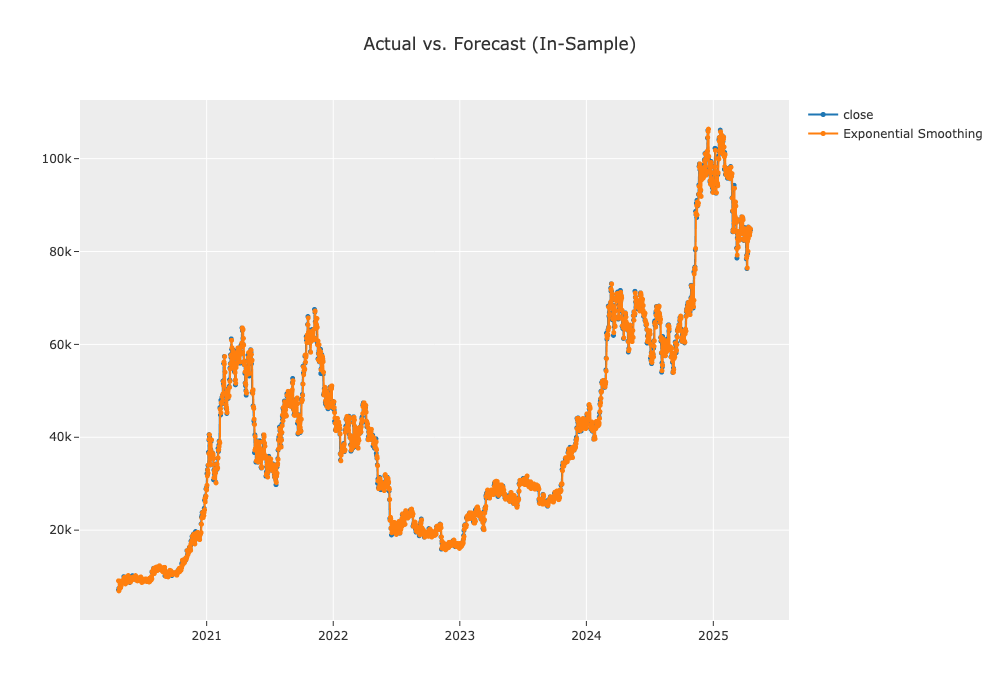

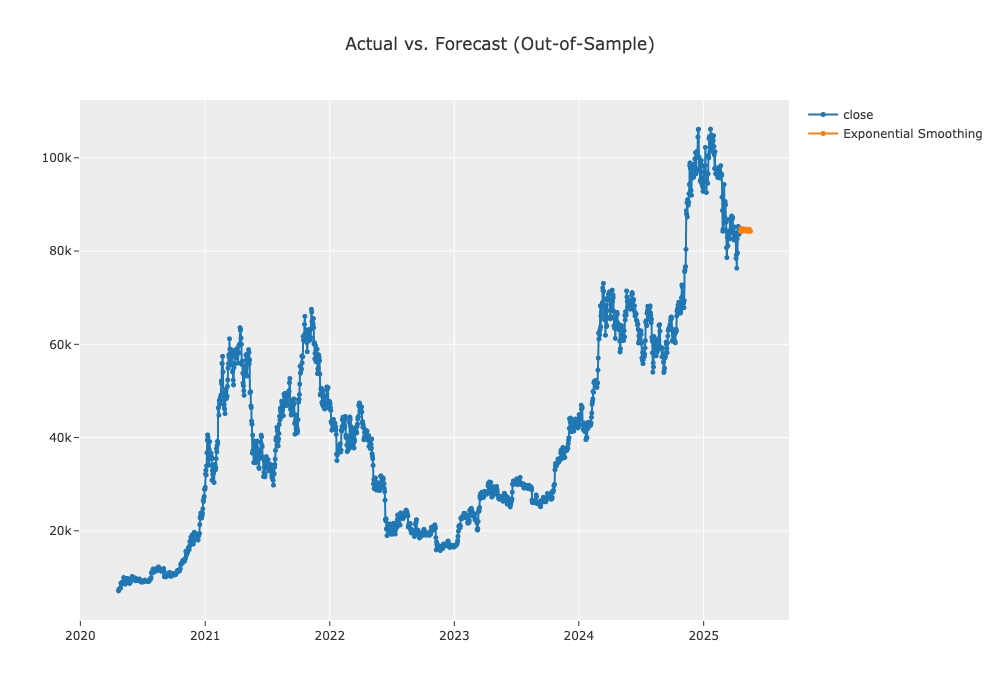

In [11]:
# btc_test.index.to_period()
# test_data_period = btc_test.copy()
# test_data_period.index = test_data_period.index.to_period()
# y_pred_final = predict_model(final_auto_arima, X=test_data_period[['lag_1','lag_2']], fh=29)

# pred_final_dt = y_pred_final.index.to_timestamp()

# y_true_final_pred = btc_5y_close_df.loc[pred_final_dt.min():pred_final_dt.max()]
# y_true_final_pred["predictions"] = y_pred_final.values

# fig = px.line(y_true_final_pred, y=['close', 'predictions'], template='plotly_dark', labels={"value" : "close price $"})

# fig.show()

exp.plot_model(final_auto_arima, plot='insample')
exp.plot_model(final_auto_arima, plot='forecast')

In [12]:
# TODO - experiment with log transform to smooth the trend. this is unlikely to improve the predictions other than increase generalisation.

# observations

## poor training performance

The test predictions exibit a lagged overfit, where the predicted values look very similar to the true values and pattern, lagged by one day.

This is expected due to the highly autocorrleated data. Particularly from the past 1 to 2 days (which can also be seen from the PACF analysis). The predicted values are a weighted average of past observations. Therefore, this will cause predictions to follow the trend more closely, appearing to lag behind the true values.

Hyndman, R. J., & Athanasopoulos, G. (2021). Forecasting: Principles and Practice. [text](https://otexts.com/fpp3/expsmooth.html)

With respect to furture forecasting. the forecast values will appear a smoothed version of the actual data. Due to the high autocorrelation, the recent values will dominate the predictions and older values (still of importance in this case because BTC is on a rise), will not contribue effectively for making useful predictions.

This will be similar to ARIMA models that rely on autoregressive components. Durbin, J., & Koopman, S. J. (2012). Time Series Analysis by State Space Methods. [Autocorrelation](https://global.oup.com/academic/product/time-series-analysis-by-state-space-methods-9780199641178)

The high autocorrelation will be inherently similar to lagged observations, a reflection of the data's characteristics.

## poor prediciton performance

overgenerlisation on the recent trend without realising a a general upward direction for BTC close price value.

# differencing the data
from the prior time series decomposition, attemping to transform the data didn't make the data more normally distributed. So trying to derive stationarity from the data may not aid this model much.

In [13]:
btc_5y_close_df['close_diff'] = btc_5y_close_df['close'].diff()
btc_5y_close_df.dropna(inplace=True)

btc_5y_close_df.head()

exp_diff = TSForecastingExperiment().setup(
    data=btc_5y_close_df['close_diff'], 
    target="close_diff",
    session_id=123, 
    fold=3,  # K-fold cross-validation
    fh=30,
)

,Description,Value
0,session_id,123
1,Target,close_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1822, 1)"
5,Transformed data shape,"(1822, 1)"
6,Transformed train set shape,"(1792, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [14]:
exp_smooth_diff = exp_diff.create_model('exp_smooth')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-19,1.3376,1.1796,1673.8997,2163.1421,3.3343,1.6504,0.0048
1,2025-01-18,1.2322,1.0455,1572.4498,1955.3445,2.3984,1.6833,-0.1499
2,2025-02-17,1.8406,1.6909,2376.6782,3193.0795,0.9719,1.6098,0.0032
Mean,NaT,1.4701,1.3053,1874.3426,2437.1887,2.2349,1.6479,-0.0473
SD,NaT,0.2655,0.2781,357.6114,541.1858,0.9714,0.0301,0.0725


In [15]:
# check the performance of the baseline model using the train set (not the validation data held off in the earlier step)
import numpy as np
import plotly.express as px

def reconstruct_undiff(model, plot=True, future=False):
    y_predict = exp_diff.predict_model(model)
    y_predict.index = y_predict.index.to_timestamp()

    if future:
        last_known = 1
    else:
        last_known = len(y_predict)
    
    # find the last known value of the train data to restore the original scale
    last_known_value = btc_5y_close_df['close'].iloc[-last_known]

    # invert the differencing to reconstruct predictions on the original scale
    y_predict_original = y_predict.cumsum() + last_known_value

    # combine true values and predictions for vis
    if future:
        # y_pred_final_diff = y_predict_original.rename(columns={"y_pred": "close"})
        y_true_pred_df = pd.concat([btc_5y_close_df['close'].iloc[-len(y_predict):].to_frame(),
                                        y_predict_original], axis=0, copy=True)
    else:
        y_true_pred = btc_5y_close_df.loc[y_predict_original.index]
        y_true_pred["predictions"] = y_predict_original

    if plot:
        if future:
            fig = px.line(y_true_pred_df, y=['close', 'y_pred'], template='plotly_dark', labels={"value": "close price $"})
        else:
            fig = px.line(y_true_pred, y=['close', 'predictions'], template='plotly_dark', labels={"value" : "close price $"})
            
        fig.show()



In [16]:
reconstruct_undiff(exp_smooth_diff)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,1.2176,1.1392,1603.2022,2197.2600,1.0649,1.5861,0.0114


In [17]:
tuned_exp_smooth_diff = exp_diff.tune_model(exp_smooth_diff)


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-19,1.3022,1.1412,1629.6819,2092.7786,3.9657,1.6606,0.0685
1,2025-01-18,1.0984,0.9335,1401.7186,1745.7825,2.6326,1.5628,0.0834
2,2025-02-17,1.8204,1.6949,2350.5394,3200.7239,1.0222,1.5688,-0.0015
Mean,NaT,1.4070,1.2565,1793.9799,2346.4283,2.5402,1.5974,0.0501
SD,NaT,0.3039,0.3214,404.4013,620.4661,1.2035,0.0448,0.0370


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished


In [18]:
reconstruct_undiff(tuned_exp_smooth_diff)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,1.2419,1.1864,1635.2009,2288.3155,1.1406,1.4772,-0.0723


In [19]:
final_exp_diff = exp_diff.finalize_model(tuned_exp_smooth_diff)


In [20]:
# y_pred_final_diff
reconstruct_undiff(final_exp_diff, future=True)

# Try comparing other models on the univariate differenced data

In [29]:
exp_diff_comp = TSForecastingExperiment().setup(
    data=btc_5y_close_df['close_diff'], 
    target="close_diff",
    session_id=345, 
    fold=3,  # K-fold cross-validation
    fh=30,
)
best = exp_diff_comp.compare_models(include=['grand_means',
    'polytrend', 'prophet', 'dt_cds_dt', 'rf_cds_dt',
    'ada_cds_dt', 'lightgbm_cds_dt'],sort='R2')

,Description,Value
0,session_id,345
1,Target,close_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1822, 1)"
5,Transformed data shape,"(1822, 1)"
6,Transformed train set shape,"(1792, 1)"
7,Transformed test set shape,"(30, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.4580,1.2730,1858.6604,2376.9244,1.9549,1.6462,0.0222,1.5700
grand_means,Grand Means Forecaster,1.4330,1.2943,1827.3198,2416.5838,1.1143,1.8539,-0.0185,1.1433
polytrend,Polynomial Trend Forecaster,1.4387,1.2966,1834.6272,2420.8884,1.2917,1.7965,-0.0229,0.4133
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.4868,1.3070,1896.2664,2441.0714,2.6096,1.5458,-0.0511,0.5767
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.4932,1.3161,1903.6310,2457.2918,2.4823,1.7286,-0.0653,0.7267
prophet,Prophet,1.4702,1.3208,1874.8688,2466.1728,1.8852,1.6442,-0.0669,0.4667
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,2.0150,1.6984,2567.4396,3168.4573,7.5814,1.5684,-0.8356,0.7800


In [30]:
reconstruct_undiff(best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,RandomForestRegressor,1.1555,1.1438,1521.5473,2206.0516,1.4115,1.4055,0.0035


In [31]:
tuned_best = exp_diff_comp.tune_model(best)


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-19,1.2886,1.1746,1612.6179,2154.0852,1.2050,1.5987,0.0131
1,2025-01-18,1.1204,0.9490,1429.8023,1774.8569,2.5318,1.6544,0.0526
2,2025-02-17,1.8418,1.6935,2378.1597,3198.0131,1.1578,1.6662,0.0001
Mean,NaT,1.4169,1.2724,1806.8600,2375.6517,1.6315,1.6398,0.0220
SD,NaT,0.3081,0.3117,410.8065,601.7542,0.6369,0.0294,0.0223


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.6s finished


In [32]:
reconstruct_undiff(tuned_best)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,RandomForestRegressor,1.1709,1.1426,1541.7756,2203.8583,1.3086,1.4074,0.0054


In [33]:
final_best = exp_diff_comp.finalize_model(tuned_best)


In [34]:
reconstruct_undiff(final_best, future=True)